# Курс "Программирование на языке Python. Уровень 4. Анализ и визуализация данных на языке Python. Библиотеки numpy, pandas, matplotlib"

## Модуль 10. Анализ данных и алгоритмы машинного обучения

1. Математические библиотеки Python и их применение для анализа/предобработки данных - пример полиномиальной регрессии
1. Кластеризация данных и ее роль в отборе признаков и пре-процессинге
2. Анализ продуктовой корзины
2. Применение scipy/sklearn для отбора признаков
5. Полезные ссылки

__Для работы потребуются следующе датасеты:__
- [data/web_traffic.tsv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/web_traffic.tsv)
- [data/store_data.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/store_data.csv)
- [data/credit_scoring.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/credit_scoring.csv)

Для некоторых датасетов, которые мы будем сегодня загружать из интернета, может потребоваться порядка 500МБ дискового простанства.


__ВНИМАНИЕ__! Установите библиотеки scipy, sklearn и mlxtend: ```pip install scipy sklearn mlxtend```

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7.0, 7.0)
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('always', category=UserWarning)

### Пример применения полиномиальной регрессии для моделирования данных

Допустим, у нас есть ежечасная статистика веб-траффика по некоторому серверу. Нам нужно определить, когда по времени, с учетом текущей динамики, количество запросов превысит 50000/час, чтобы заранее проапгрейдить оборудование. Для этого мы попытаемся построить кривую с помощью полиномиальной регрессии и экстраполируя ее на будущее, определим крайний срок для апгрейда оборудования.

In [ ]:
web_traffic = pd.read_csv('data/web_traffic.tsv', sep='\t', header=None, names=['Hour', 'ReqsPerHour'], index_col='Hour')
web_traffic.head()

Разберемся с пропущенными данными:

In [ ]:
web_traffic.isnull().sum()

In [ ]:
web_traffic.dropna(inplace=True)

In [ ]:
web_traffic.shape

Напишем функцию для красивого отображения данных и моделей:

In [ ]:
def plot_models(x, y, models, mx=None, ymax=None, xmin=None):
    ''' plot input data '''
    
    colors = ['g', 'k', 'b', 'm', 'r']
    linestyles = ['-', '-.', '--', ':', '-']

    plt.figure(num=None, figsize=(10, 6))
    plt.clf()
    
    plt.scatter(x, y, s=10, label='data')
    
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = np.linspace(0, x.shape[0], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color, label=f"d={model.order}")

    plt.legend(loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    
plot_models(web_traffic.index, web_traffic.ReqsPerHour, None)

In [ ]:
x, y = web_traffic.index, web_traffic.ReqsPerHour

fp1, res1, rank1, sv1, rcond1 = np.polyfit(x, y, 1, full=True)
print("Model parameters of fp1: %s" % fp1)
print("Error of the model of fp1:", res1)
f1 = np.poly1d(fp1)

In [ ]:
plot_models(x, y, [f1])

Обучим еще несколько моделей с более высокой степенью многочлена:

In [ ]:
fp2, res2, rank2, sv2, rcond2 = np.polyfit(x, y, 2, full=True)
print("Model parameters of fp2: %s" % fp2)
print("Error of the model of fp2:", res2)
f2 = np.poly1d(fp2)
f3 = np.poly1d(np.polyfit(x, y, 3))
f10 = np.poly1d(np.polyfit(x, y, 10))
f100 = np.poly1d(np.polyfit(x, y, 100))

Нарисуем эти модели

In [ ]:
plot_models(x, y, [f1, f2, f3, f10, f100])

Замечаем, что точка перегиба нашего графика находится примерно на середине второй недели. Повторим обучение наших моделей с этим смещением.

In [ ]:
# fit and plot a model using the knowledge about inflection point
inflection = int(2.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = np.poly1d(np.polyfit(xa, ya, 1))
fb = np.poly1d(np.polyfit(xb, yb, 1))

In [ ]:
plot_models(x, y, [fa, fb])

In [ ]:
# fit and plot a model using the knowledge about inflection point
inflection = int(3.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = np.poly1d(np.polyfit(xa, ya, 1))
fb = np.poly1d(np.polyfit(xb, yb, 1))
plot_models(x, y, [fa, fb])

Нарисуем существующие модели с экстраполяцией в недалекое будущее (до 6-й недели с начала наблюдений)

In [ ]:
plot_models(
    x, y, [f1, f2, f3, f10, f100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

А также создадим несколько моделей, обученных на данных только после второй точки перегиба:

In [ ]:
fb1 = fb
fb2 = np.poly1d(np.polyfit(xb, yb, 2))
fb3 = np.poly1d(np.polyfit(xb, yb, 3))
fb10 = np.poly1d(np.polyfit(xb, yb, 10))
fb100 = np.poly1d(np.polyfit(xb, yb, 100))

Нарисуем их:

In [ ]:
plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

#### Оценим точность 

Напишем функцию которая считает среднеквадратичную ошибку для модели и посмотрим, на сколько точны наши первоначальные модели:

In [ ]:
def error(f, x, y):
    return np.sum((f(x) - y) ** 2)

print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format (f.order, error(f, x, y)))

...и оценим их же точность, но только после точки перегиба:

In [ ]:
print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format(f.order, error(f, xb, yb)))

...и теперь точность моделей, обученных после точки перегиба:

In [ ]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

Выберем победительницей модель с полиномом в степени 2. Рассчитаем дату достижения предела в 50000 запросов.

In [ ]:
from scipy.optimize import fsolve
reached_max = fsolve(fb2 - 50000, x0=800) / (7 * 24)
print("50,000 hits/hour expected at week %f" % reached_max[0])

Нарисуем:

In [ ]:
plot_models(
    x, y, [fb2],
    mx=np.linspace(0 * 7 * 24, 8 * 7 * 24, 100),
    ymax=50000, xmin=0 * 7 * 24)

### Пример 2. Кластеризация 

В качестве визуальной оценки данных используется кластеризация.

In [ ]:
!conda install -y scikit-learn

In [ ]:
from sklearn.decomposition import PCA

Метод PCA (метод главных компонент) позволяет уменьшить размерность датасета до 2 (или 3).  Это позволяет визуально оценить "обучаемость" алгоритмов на этих данных. Также метод позволяет выяснить, из чего состоят итоговые компоненты. В основе этого метода лежит сингулярное разложение векторов (SVD). Рассмотрим на примере набора данных "Ирисы":

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

iris.data.shape

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, cmap='viridis')
plt.show()

In [ ]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [ ]:
from ipywidgets import interact

def irises_3D(elev=30, azim=30, roll=0):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elev, azim=azim, roll=roll)
    ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


interact(irises_3D, elev=(-90, 90), azim=(-180, 180), roll=(-90, 90));

Рассмотрим на примере датасета "рукописные цифры". Здесь размерность уменьшена с 64 до 2.

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [ ]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='nipy_spectral')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Пример кластеризации по t-SNE.

In [ ]:
from sklearn.manifold import TSNE

plt.figure(figsize=(8,8))

tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=sns.color_palette("bright", 10))

In [ ]:
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(X)

ig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter( X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap='nipy_spectral')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [ ]:
def digits_3D(elev=30, azim=30, roll=0):
    ig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elev, azim=azim, roll=roll)
    ax.scatter( X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap='nipy_spectral')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

interact(digits_3D, elev=(-90, 90), azim=(-180, 180), roll=(-90, 90));

### Пример 3. Анализ покупательской корзины

Это пример "майнинга данных" - поиска зависимостей и закономерностей в массиве данных. "Анализ покупательской корзины" - довольно часто использующийся метод при построении рекомендательных систем. Базовый алгоритм называется ```Apriori```, он был предложен в 1994 году.

Назначение алгоритма - поиск часто встречающихся подмножеств. Он оперирует следующими понятиями:
 - "суппорт" $Support A$ - вероятность покупки товара A, ее можно вычислить как отношение количества покупок A к общему количеству покупок.
 - "конфидент" $Conf  A{\rightarrow}B$  - вычисляется для пары товаров A и B как отношение случаев совместного приобретения этих товаров к покупкам артикула A
 - "подъем" $Lift  A{\rightarrow}B$  - это отношение вероятности приобретения пары товаров A и B к вероятности приобретения товара A. Или попросту говоря, отношение "конфидента" к "суппорту".
 
Давайте "вытащим" из датасета с данными о покупках в некотором французском супермаркете самые популярные товары и их сочетания с помощью алгоритма ```Apriori```.


Посмотрим на содержимое файла и загрузим датасет:

In [ ]:
with open('data/store_data.csv') as f:
    for i in range(10):
        print(f"{i}:", f.readline().strip())

In [ ]:
df_store = pd.read_csv('data/store_data.csv', header=None)
print(df_store.shape)
df_store.head()

Посмотрим на список артикулов и их количество:

In [ ]:
df_store.stack().unique()

На базе исходного dataframe создадим dataframe, в котором признаки приобретения того или иного товара станут булевыми dummy признаками. Для этого мы ему сначала сделаем ```stack()```, получим dummy-признаки, а затем сгруппируем по индексу первого уровня со взятием максимума:

In [ ]:
df_dummies = pd.get_dummies(df_store.stack()).groupby(level=0).max().astype(int)
df_dummies

Запустим алгоритм Apriori и получим список наиболее часто приобретаемых товаров и их сочетаний:

In [ ]:
!pip install mlxtend

In [ ]:
from mlxtend.frequent_patterns import apriori

df_apriori = apriori(df_dummies, min_support=0.01, use_colnames=True)
df_apriori

Отсортируем список:

In [ ]:
df_apriori.sort_values('support', ascending=False)

Теперь получим список самых популярных сочетаний для 2-х и 3-х товаров в корзине:

In [ ]:
df_apriori['item_count'] = df_apriori['itemsets'].apply(len)
df_apriori[ df_apriori.item_count >=2 ].sort_values('support', ascending=False)

### Пример 4. Отбор и преобразование признаков для задач машинного обучения

Решается задача кредитного скоринга. 

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный)

Задача: обучить модель, способную предсказывать вероятность просрочки выплаты по кредиту более чем на 90 дней.

In [ ]:
df = pd.read_csv('data/credit_scoring.csv', index_col='client_id')
df

In [ ]:
df.shape

In [ ]:
df.info()

Как обычно, проверим на NaN:

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

Построим матрицу диаграмм рассеяния:

In [ ]:
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha':0.2});

Рассмотрим признак ```Income```:

In [ ]:
sns.histplot(df.Income, kde=True);

In [ ]:
df.Income.hist();

Что делать с такими данными?

**Способ 1**: логарифмировать

In [ ]:
np.log(0)

In [ ]:
(df.Income.round(2) == 0.0).sum()

In [ ]:
mask = (df.Income.round(2) == 0.0)
df.loc[mask, 'Income'] += 1
sns.histplot(np.log10(df.Income), kde=True);

**Способ 2**: распределить по категориям согласно квантилям

In [ ]:
quantiles = 10
cats_income, bins = pd.qcut(df.Income, 
                      q=quantiles, 
                      labels=range(1,quantiles+1),
                      retbins=True
                     )
print(bins)
cats_income

In [ ]:
plt.bar(cats_income.cat.categories, cats_income.value_counts())
plt.xticks(cats_income.cat.categories, np.round(bins[1:]).astype(int))
plt.show()

Заменим NaN:

In [ ]:
df['Income'] = df['Income'].fillna(df['Income'].median())

Теперь посмотрим на признак ```NumDependents```:

In [ ]:
df['NumDependents'].value_counts().sort_index()

In [ ]:
df['NumDependents'] = df['NumDependents'].fillna(0)
df.isnull().sum()

Сделаем копию исходного сета, чтобы затем сравнить как обучалась модель на исходных данных и после преобразования:

In [ ]:
df_src = df.copy()

Прологарифмируем признак "доход" и удалим исходные данные:

In [ ]:
df['Income_log10'] = np.log10(df.Income)
df.drop(['Income'], axis=1, inplace=True)
df

Посмотрим на признаки по дням просрочки:

In [ ]:
df['Num30-59Delinquencies'].value_counts().sort_index()

In [ ]:
df['Num60-89Delinquencies'].value_counts().sort_index()

Преобразуем их в бинарные dummy-признаки по категориям: "без просрочки", "одна-две просрочки" и "более трех".

In [ ]:
bins = [0,1,3,100]
labels = ['none', 'onetwo', 'threemore']
pd.get_dummies( pd.cut(df['Num30-59Delinquencies'], bins, labels=labels, right=False),
               prefix='deliq30')

In [ ]:
df = df.join([pd.get_dummies( pd.cut(df['Num30-59Delinquencies'], bins, labels=labels, right=False),
               prefix='deliq30'),
              pd.get_dummies( pd.cut(df['Num60-89Delinquencies'], bins, labels=labels, right=False),
               prefix='deliq60'),
             ])
df.drop(['Num30-59Delinquencies', 'Num60-89Delinquencies'], axis=1, inplace=True)

In [ ]:
df

Проверим сбалансированность классов в результирующем признаке:

In [ ]:
pd.DataFrame({'counts': df['Delinquent90'].value_counts(), 'pct': 100*df['Delinquent90'].value_counts()/df.shape[0]})

Сразу обучим "сильную" модель - "случайный лес":

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split

Создадим обучающую и тестовую выборку:

In [ ]:
y = df['Delinquent90']
X = df.drop(columns=['Delinquent90'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20211210,
                                                   stratify = y)

In [ ]:
forest = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=-1, class_weight={0:1, 1:13}) 
forest.fit(X_train,y_train)

Посмотрим на точность работы модели:

In [ ]:
test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

Теперь сделаем то же самое, но с необработанными данными:

In [ ]:
df_src

In [ ]:
y = df_src['Delinquent90']
X = df_src.drop(columns=['Delinquent90'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20211210,
                                                   stratify = y)

forest = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=-1, class_weight={0:1, 1:13}) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

Для выбора лучших параметров модели используют класс ```GridSearchCV```:

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [10],
    'max_depth': range(7, 10+1)
}

model = RandomForestClassifier(class_weight={0:1, 1:13})
gs = GridSearchCV(model, params, scoring='roc_auc', cv=5)

gs.fit(X, y)
best_forest = gs.best_estimator_
print(best_forest)
gs.best_score_


Обучим модель с лучшими параметрами и снимем метрики:

In [ ]:
forest = RandomForestClassifier(n_estimators=30, max_depth=7, n_jobs=-1, class_weight={0:1, 1:13}) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

Теперь подберем лучшую модель для модифицированного датасета:

In [ ]:
df

In [ ]:
y = df['Delinquent90']
X = df.drop(columns=['Delinquent90'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20211210,
                                                   stratify = y)

In [ ]:
params = {
    'n_estimators': range(26, 50+1),
     'max_depth': [7]
}

model = RandomForestClassifier(class_weight={0:1, 1:13})
gs = GridSearchCV(model, params, scoring='roc_auc', cv=5)

gs.fit(X, y)
best_forest = gs.best_estimator_
print(best_forest)
gs.best_score_

Так же обучим модель с лучшими параметрами и снимем метрики:

In [ ]:
forest = RandomForestClassifier(class_weight={0: 1, 1: 13}, max_depth=8, n_estimators=48) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

In [ ]:
indices = np.argsort(forest.feature_importances_)[::-1]

for i in range(X_train.shape[1]):
    print(f"{i+1}. {X_train.columns[ indices[i] ]:25} {forest.feature_importances_[indices[i]]:.4f}")

Теперь посмотрим на признак ```BalanceToCreditLimit```:

In [ ]:
df['BalanceToCreditLimit'].describe()

In [ ]:
(df['BalanceToCreditLimit']>5).sum()

In [ ]:
((df['BalanceToCreditLimit']>5) & (df['Delinquent90']==1)).sum()

In [ ]:
quantiles = 10
cats_bal, bins = pd.qcut(df.BalanceToCreditLimit, 
                      q=quantiles, 
                      labels=range(1,quantiles+1),
                      retbins=True
                     )
print(bins)
cats_bal

In [ ]:
df_B2CL = pd.get_dummies( pd.cut(df['BalanceToCreditLimit'], bins, labels=cats_bal.cat.categories, right=False),
               prefix='B2CL')
df_B2CL

In [ ]:
df = df.join(df_B2CL)
df.drop('BalanceToCreditLimit', axis=1, inplace=True)
df

Снова обучим модель (лучшей предыдущей конфигурации) и снимем метрики:

In [ ]:
y = df['Delinquent90']
X = df.drop(columns=['Delinquent90'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20211210,
                                                   stratify = y)

forest = RandomForestClassifier(class_weight={0: 1, 1: 13}, max_depth=8, n_estimators=48, random_state=42) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

In [ ]:
indices = np.argsort(forest.feature_importances_)[::-1]

for i in range(X_train.shape[1]):
    print(f"{i+1}. {X_train.columns[ indices[i] ]:25} {forest.feature_importances_[indices[i]]:.4f}")

In [ ]:
fi = forest.feature_importances_
fi

In [ ]:
cols = X_train.columns
cols

In [ ]:
cols[ fi < 0.05 ]

In [ ]:
df_dropped5pct = df.drop(cols[ fi < 0.05], axis=1)
df_dropped5pct

И опять обучим модель (лучшей предыдущей конфигурации) и снимем метрики:

In [ ]:
y = df_dropped5pct['Delinquent90']
X = df_dropped5pct.drop(columns=['Delinquent90'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20211210,
                                                   stratify = y)

forest = RandomForestClassifier(class_weight={0: 1, 1: 13}, max_depth=8, n_estimators=48) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

In [ ]:
cols[ fi < 0.01]

In [ ]:
df_dropped1pct = df.drop(cols[ fi < 0.01], axis=1)
df_dropped1pct

In [ ]:
y = df_dropped1pct['Delinquent90']
X = df_dropped1pct.drop(columns=['Delinquent90'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20211210,
                                                   stratify = y)

forest = RandomForestClassifier(class_weight={0: 1, 1: 13}, max_depth=8, n_estimators=48) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

Снова попробуем подобрать лучшую модель:

In [ ]:
params = {
    'n_estimators': [57],
     'max_depth': range(5,10+1)
}

model = RandomForestClassifier(class_weight={0:1, 1:13}, random_state=42)
gs = GridSearchCV(model, params, scoring='roc_auc', cv=5)

gs.fit(X, y)
best_forest = gs.best_estimator_
print(best_forest)
gs.best_score_

In [ ]:
forest = RandomForestClassifier(class_weight={0: 1, 1: 13}, max_depth=8, n_estimators=57, random_state=42) 
forest.fit(X_train,y_train)

test_pred = forest.predict(X_test)
test_pred_proba = forest.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

И для сравнения, обучим "дерево решений":

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight={0: 1, 1: 13}, max_depth=8, random_state=42)
tree.fit(X_train, y_train)

Посмотрим на точность рассчетов:

In [ ]:
test_pred = tree.predict(X_test)
test_pred_proba = tree.predict_proba(X_test)
auc = roc_auc_score(y_test, test_pred_proba[:, 1])
print("Accuracy score: {}, f1: {}, auc: {}".format(accuracy_score(y_test, test_pred),\
                                                   f1_score(y_test, test_pred), \
                                                  auc))

### Разные примеры

1. Анимация в Jupyter Notebook

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.animation as animation

# !!! ВАЖНО!
%matplotlib notebook 


def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
plt.show()

2. Нейронные сети

В рамках данной демонстрации мы, конечно, не будем углубляться во все тонкости обучения, настройки и использования нейросетей, это тема для отдельного курса. Ниже - просто пример использования сети imagenet в задаче распознавания образов (пример из 2017 года): 

In [ ]:
import keras
keras.__version__

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(weights='imagenet')

In [ ]:
# Загрузим изображение
img_path = 'data/images/creative_commons_elephant.jpg'
# img_path = 'data/images/demo_cat.jpg'

img_full = image.load_img(img_path)
plt.imshow(img_full)

In [ ]:
# выполним необходимый пре-процессинг изображения и вызовем функцию predict()

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [ ]:
# узнать об архитектуре и свойствах модели можно с помощью функции summary()

model.summary()

...а теперь пример из 2020 года, нейросеть YOLOv5

In [ ]:
!pip install -U ultralytics

In [ ]:
import torch
import cv2
from PIL import Image

yolo = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)

In [ ]:
# Загрузим изображение
img_path = 'data/images/creative_commons_elephant.jpg'
# img_path = 'data/images/demo_cat.jpg'

img = image.load_img(img_path)
display(img)

In [ ]:
results = yolo([img])

results.pandas().xyxy[0]

In [ ]:
df = results.pandas().xyxy[0]

tl=2
tf = max(tl - 1, 1)

img_np = np.array(img)

for i, row in df.iterrows():
    xA, yA, xB, yB = map(int, row[:4])
    cv2.rectangle(img_np, (xA, yA), (xB, yB), (0, 255, 0), tl)
    cv2.putText(img_np, row['name'], (xA, yA - 2), 0, tl / 3, [0, 255, 0], thickness=tf, lineType=cv2.LINE_AA) 
    
display(Image.fromarray(img_np))

In [ ]:
print(yolo)

### Пример GAN - стилизация фотографий под аниме

Используется нейросеть AnimeGANv2 (https://github.com/TachibanaYoshino/AnimeGANv2/).

In [ ]:
import onnxruntime as ort
import cv2
import os

from IPython import display

In [ ]:
image_path = 'data/images/lena.jpg'
onnx = 'data/images/Hayao.onnx'
# onnx = 'data/images/Shinkai_53.onnx'
result_dir = 'data/images'

result_path = os.path.join(result_dir,'{0}'.format(os.path.basename(onnx).replace('.onnx', '')+'_'+os.path.basename(image_path)))

# display.Image(image_path)

def process_image(img, x32=True):
    h, w = img.shape[:2]
    if x32: # resize image to multiple of 32s
        def to_32s(x):
            return 256 if x < 256 else x - x%32
        img = cv2.resize(img, (to_32s(w), to_32s(h)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/ 127.5 - 1.0
    return img

def save_images(images, image_path, size):
    images = (np.squeeze(images) + 1.) / 2 * 255
    images = np.clip(images, 0, 255).astype(np.uint8)
    images = cv2.resize(images, size)
    cv2.imwrite(image_path, cv2.cvtColor(images, cv2.COLOR_RGB2BGR))

img0 = cv2.imread(image_path).astype(np.float32)
img = process_image(img0, [256, 256])
img = np.expand_dims(img, axis=0)

session = ort.InferenceSession(onnx, None)
x = session.get_inputs()[0].name
y = session.get_outputs()[0].name

fake_img = session.run(None, {x : img})
save_images(fake_img[0], result_path, (img0.shape[1], img0.shape[0]))
print(result_path)
display.Image(result_path)

### ПОЛЕЗНОЕ

1. Зарегистрируйтесь на https://kaggle.com
2. Читайте специальный раздел на Medium [TowardsDataScience.com](https://towardsdatascience.com)
3. Оттуда - пара статей про векторизацию кода: [1](https://medium.com/@mikeliao/numpy-vectorization-d4adea4fc2a) и [2](https://towardsdatascience.com/python-vectorization-5b882eeef658)
5. Рекомендую книгу о векторизации ["From Python to Numpy"](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)
4. Еще можно бесплатно пройти курсы Стэнфорского Университета: "Машинное обучение", [CS229](http://cs229.stanford.edu/), "Глубокое обучение", [CS231n](http://cs231n.stanford.edu/).


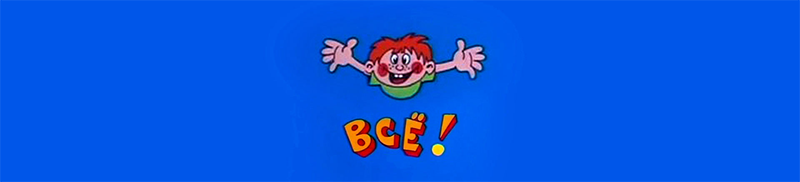